# Importing Libraries

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.15.0


In [29]:
import os, random, json, PIL, shutil, re , glob
import numpy as np

import cv2
import pandas as pd
import seaborn as sns
from PIL import ImageDraw
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
# import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback
import math
from sklearn.model_selection import train_test_split
# import imageio.v3 as iio

# Import Dataset

In [30]:
IMAGE_SIZE = [256, 256]
def count_data_files(names):
    n = [int(re.compile(r"-([0-9]*)\.").search(name).group(1)) for name in names]
    return np.sum(n)
def get_normalized(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = get_normalized(example['image'])
    return image
    
def load_dataset(files, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat(5)
    return dataset

In [31]:
# path = KaggleDatasets().get_gcs_path()
monet_files = tf.io.gfile.glob(str('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'))
photo_files = tf.io.gfile.glob(str('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'))

# Split the Monet and photo files into training and validation sets
monet_train_files, monet_val_files = train_test_split(monet_files, test_size=0.2, random_state=42)
photo_train_files, photo_val_files = train_test_split(photo_files, test_size=0.2, random_state=42)

# Load the training and validation datasets
monet_train_images = load_dataset(monet_train_files, labeled=True).batch(4)
photo_train_images = load_dataset(photo_train_files, labeled=True).batch(4)
monet_val_images = load_dataset(monet_val_files, labeled=True).batch(4)
photo_val_images = load_dataset(photo_val_files, labeled=True).batch(4)


In [32]:
# Count the number of samples in the training and validation sets
n_monet_train_samples = count_data_files(monet_train_files)
n_photo_train_samples = count_data_files(photo_train_files)
n_monet_val_samples = count_data_files(monet_val_files)
n_photo_val_samples = count_data_files(photo_val_files)

print(f'Training Monet images: {n_monet_train_samples}')
print(f'Training Photo images: {n_photo_train_samples}')
print(f'Validation Monet images: {n_monet_val_samples}')
print(f'Validation Photo images: {n_photo_val_samples}')

Training Monet images: 240
Training Photo images: 5630
Validation Monet images: 60
Validation Photo images: 1408


# Visualization

In [33]:
def visualize_images(ds, title, samples=5):
    num_cols = min(samples, 5)
    num_rows = (samples + num_cols - 1) // num_cols
    plt.figure(figsize=(4*num_cols, 4*num_rows))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(f'{title} {i+1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

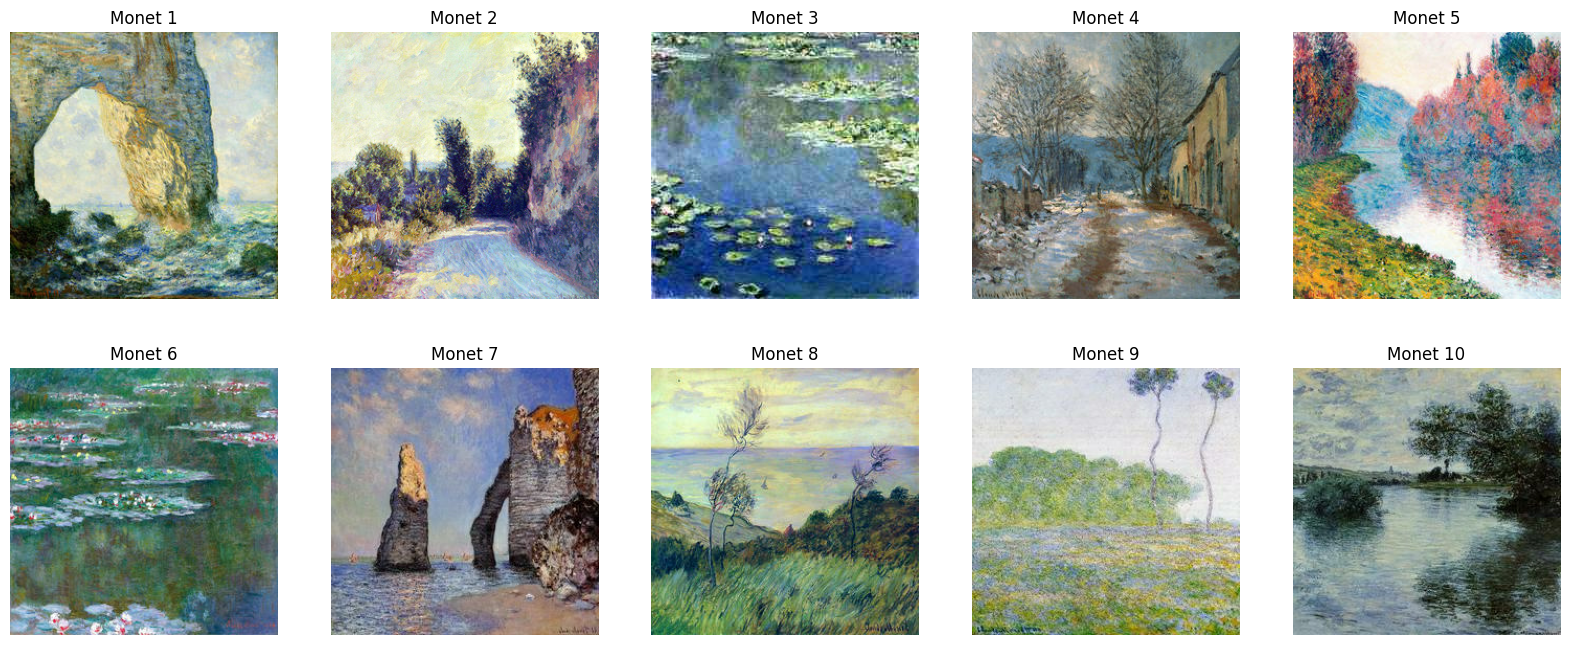

In [34]:
visualize_images(monet_train_images,'Monet',10)

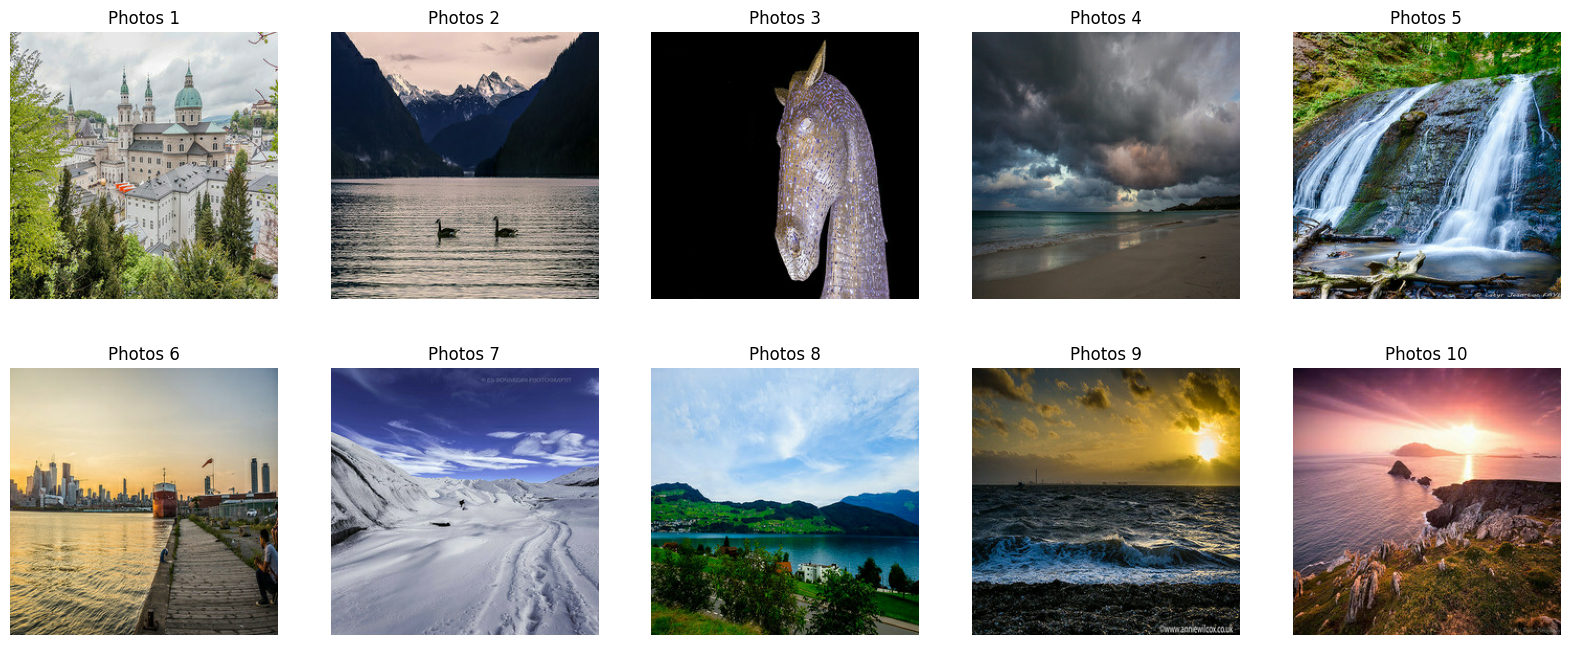

In [35]:
visualize_images(photo_train_images,'Photos',10)

# Generator

In [36]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(keras.layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

In [37]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Discriminator

In [38]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [39]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, apply_batchnorm=False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,  kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)


In [40]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

# Build CycleGans

In [41]:
class CycleGan(keras.Model):
    def __init__(
        self,monet_generator,photo_generator,monet_discriminator,photo_discriminator,lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn, identity_loss_fn ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))
    
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [42]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

# Loss Functions

## Discriminator Loss

In [43]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

## Generator Loss

In [44]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

## Cycle Loss

In [45]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

## Identity Loss

In [46]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Training

In [47]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [49]:
cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

# Compile the model
cycle_gan_model.compile(
    m_gen_optimizer=monet_generator_optimizer,
    p_gen_optimizer=photo_generator_optimizer,
    m_disc_optimizer=monet_discriminator_optimizer,
    p_disc_optimizer=photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)

# Train the model using the fit method
hist = cycle_gan_model.fit(tf.data.Dataset.zip((monet_train_images, photo_train_images)), epochs=20)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 251s 504ms/step - monet_disc_loss: 0.6848 - monet_gen_loss: 4.5282 - photo_disc_loss: 0.6818 - photo_gen_loss: 4.5503 - loss: 0.0000e+00
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 502ms/step - monet_disc_loss: 0.6540 - monet_gen_loss: 3.4719 - photo_disc_loss: 0.6552 - photo_gen_loss: 3.4677 - loss: 0.0000e+00
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 503ms/step - monet_disc_loss: 0.6617 - monet_gen_loss: 3.2949 - photo_disc_loss: 0.6573 - photo_gen_loss: 3.2879 - loss: 0.0000e+00
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 502ms/step - monet_disc_loss: 0.6682 - monet_gen_loss: 3.1741 - photo_disc_loss: 0.6602 - photo_gen_loss: 3.1913 - loss: 0.0000e+00
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 502ms/step - monet_disc_loss: 0.6673 - monet_gen_loss: 3.0779 - photo_disc_loss: 0.6692 - photo_gen_loss: 3.0919 - loss: 0.0000e+00
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 503ms/step - monet_disc_loss: 0.6710 - monet_gen_loss: 2.9070 - photo_

In [51]:
print(hist.history.keys())

dict_keys(['loss'])


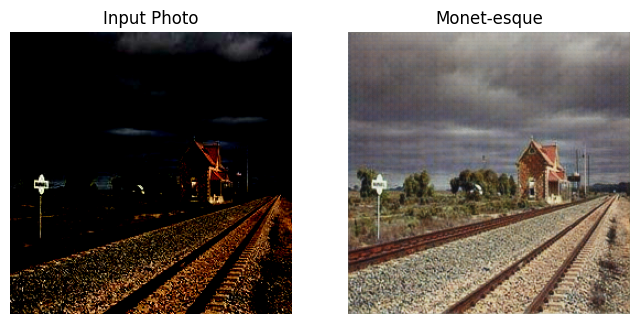

In [59]:
# import requests
# from io import BytesIO
from PIL import Image

# # Download and resize the image
# response = requests.get("https://image.shutterstock.com/image-photo/zero-waste-look-after-earth-260nw-1509436412.jpg")
# img = Image.open(BytesIO(response.content))
img = Image.open("/kaggle/input/sample-for-input/00fcff630e.jpg")
img = img.resize((256, 256))

# Convert the image to a numpy array and normalize
img = np.array(img)
img = (img / 127.5) - 1

# Generate the Monet-esque version
prediction = monet_generator(np.expand_dims(img, axis=0), training=False)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

# Display the input and output images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img)
ax[1].imshow(prediction)
ax[0].set_title("Input Photo")
ax[1].set_title("Monet-esque")
ax[0].axis("off")
ax[1].axis("off")
plt.show()

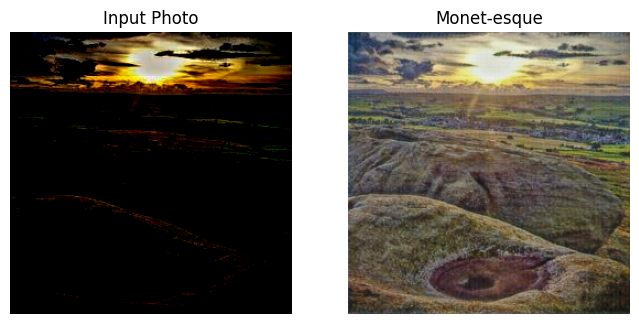

In [60]:
# import requests
# from io import BytesIO
from PIL import Image

# # Download and resize the image
# response = requests.get("https://image.shutterstock.com/image-photo/zero-waste-look-after-earth-260nw-1509436412.jpg")
# img = Image.open(BytesIO(response.content))
img = Image.open("/kaggle/input/sample-for-input/0a0d3e6ea7.jpg")
img = img.resize((256, 256))

# Convert the image to a numpy array and normalize
img = np.array(img)
img = (img / 127.5) - 1

# Generate the Monet-esque version
prediction = monet_generator(np.expand_dims(img, axis=0), training=False)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

# Display the input and output images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img)
ax[1].imshow(prediction)
ax[0].set_title("Input Photo")
ax[1].set_title("Monet-esque")
ax[0].axis("off")
ax[1].axis("off")
plt.show()

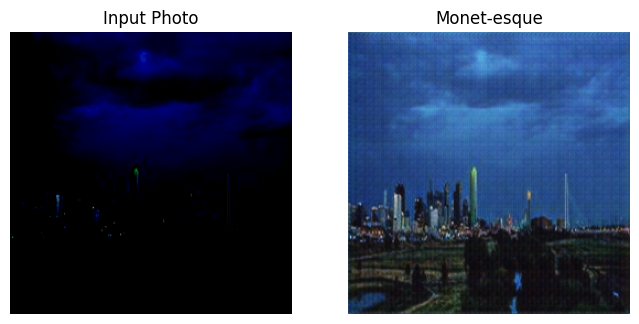

In [61]:
# import requests
# from io import BytesIO
from PIL import Image

# # Download and resize the image
# response = requests.get("https://image.shutterstock.com/image-photo/zero-waste-look-after-earth-260nw-1509436412.jpg")
# img = Image.open(BytesIO(response.content))
img = Image.open("/kaggle/input/sample-for-input/0a1d1b9f8e.jpg")
img = img.resize((256, 256))

# Convert the image to a numpy array and normalize
img = np.array(img)
img = (img / 127.5) - 1

# Generate the Monet-esque version
prediction = monet_generator(np.expand_dims(img, axis=0), training=False)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

# Display the input and output images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img)
ax[1].imshow(prediction)
ax[0].set_title("Input Photo")
ax[1].set_title("Monet-esque")
ax[0].axis("off")
ax[1].axis("off")
plt.show()

In [53]:
validation_dataset = tf.data.Dataset.zip((monet_val_images , photo_val_images))

In [62]:
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np

def evaluate_model_ssim(model, dataset):
    ssim_scores = []
    for batch_data in dataset:
        real_monet, real_photo = batch_data
        # Generate Monet-style images from real photos
        fake_monet = model.p_gen(real_photo, training=False)
        # Compute SSIM for each pair of real Monet images and fake Monet images
        for i in range(len(real_monet)):
            # Convert TensorFlow tensors to NumPy arrays
            fake_monet_np = fake_monet[i].numpy()
            real_monet_np = real_monet[i].numpy()
            # Compute SSIM
            ssim_score = compare_ssim(
                np.squeeze(tf.image.rgb_to_grayscale(fake_monet_np)),
                np.squeeze(tf.image.rgb_to_grayscale(real_monet_np)),
                data_range=1.0
            )
            ssim_scores.append(ssim_score)
    # Compute the average SSIM score
    avg_ssim_score = sum(ssim_scores) / len(ssim_scores)
    return avg_ssim_score

# Evaluate the model using SSIM
ssim_score = evaluate_model_ssim(cycle_gan_model, validation_dataset)
print("Average SSIM score:", ssim_score)


Average SSIM score: 0.20123234323433
